In [1]:
from IPython.display import Image
Image("images\strukturExample.png");

# FINE Webinar Part I: EnergyLand energy system

In this application of the FINE framework, a 1-node energy system is modeled and optimized.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity sinks are added to the energy system model
7. The energy system model is optimized
8. Selected optimization results are presented

![Structure of EnergyLand](images\strukturExample.png)

# 1. Import packages

The FINE framework is imported which provides the required classes and functions for modeling the energy system.
The working directory and the underlying excelfile which provides some of the input data is imported.

In [2]:
import FINE as fn
from getData import getData
import pandas as pd
import os
cwd = os.getcwd()
data = getData()

# 2. Set up energy system model instance

The structure of the energy system model is given by the considered locations, in this case we consider only one location (EnergyLand), commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit, which can be given as an energy or mass unit per hour.

In [3]:
locations = {'EnergyLand'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'hydrogen': r'GW$_{H_{2},LHV}$', 
                     'nGas':r'GW$_{CH4}$', 'coal':r'GW$_{coal}$', 'PHeat': r'GW$_{Pheat}$',
                     'LTHeat':r'GW$_{LTHeat}$', 'CO2':r'kt$_{CO_{2}}$/h', 'pTransport': 'Mio pkm/h',
                     'fTransport': 'Mio tkm/h', 'crudeOil': r'GW$_{Oil}$', 'wood': r'GW$_{wood}$', 
                     'biowaste': r'GW$_{biowaste}$', 'bioslurry': r'GW$_{bioslurry}$',
                     'diesel': r'GW$_{diesel}$', 'biogas': r'GW$_{CH4}$', 'nGasImp': r'GW$_{CH4}$'}
commodities = {'electricity', 'hydrogen', 'nGas', 'coal', 'PHeat', 'LTHeat', 'CO2', 'pTransport', 
               'fTransport', 'crudeOil', 'wood', 'biowaste', 'bioslurry', 'diesel', 'nGasImp', 'biogas'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [4]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e6 Euro', lengthUnit='km', verboseLogLevel=0)

# 3. Sources

Source components transfer a commodity from outside the system boundary of EnergyLand into the system.

## 3.1 Electricity sources

### Wind turbines

#### Onshore Wind Turbines

In [5]:
esM.add(fn.Source(esM=esM, name='Wind_Onshore', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind_onshore, operationRateMax'],
                  capacityMax=data['Wind_onshore, capacityMax'],
                  investPerCapacity=1250, opexPerCapacity=1250*0.02, interestRate=0.08,
                  economicLifetime=20))

#### Offshore Wind Turbines

In [6]:
esM.add(fn.Source(esM=esM, name='Wind_Offshore', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind_offshore, operationRateMax'],
                  capacityMax=data['Wind_offshore, capacityMax'],
                  investPerCapacity=2530, opexPerCapacity=2530*0.045, interestRate=0.08,
                  economicLifetime=20))

### Photovoltaic

In [7]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'],
                  capacityMax=data['PV, capacityMax'],
                  investPerCapacity=800, opexPerCapacity=800*0.019, interestRate=0.08,
                  economicLifetime=20))

### Electricity import

In [8]:
esM.add(fn.Source(esM=esM, name='el_Import', commodity='electricity', hasCapacityVariable=False,
                  operationRateMax=data['el_Import, operationRateMax']))

## 3.2 Hydrogen source

In [9]:
esM.add(fn.Source(esM=esM, name='H2_Import', commodity='hydrogen', hasCapacityVariable=False,
                  operationRateMax=data['H2_Import, operationRateMax'],
                  commodityCost=0.132))

## 3.3 Coal source

In [10]:
esM.add(fn.Source(esM=esM, name='CoalSource', commodity='coal', hasCapacityVariable=False,
                  commodityCost=0.021))

## 3.4 Crude Oil source

In [11]:
esM.add(fn.Source(esM=esM, name='CrudeOilSource', commodity='crudeOil', hasCapacityVariable=False,
                  commodityCost=0.036))

## 3.5 Natural gas source

In [12]:
esM.add(fn.Source(esM=esM, name='nGasSource', commodity='nGasImp', hasCapacityVariable=False,
                  commodityCost=0.0256))

## 3.6 Biomass sources

#### Wood Source

In [13]:
esM.add(fn.Source(esM=esM, name='WoodSource', commodity='wood', hasCapacityVariable=True,
                  capacityMax=data['wood_source, capacityMax'],
                  commodityCost=0.028))

#### Biowaste Source

In [14]:
esM.add(fn.Source(esM=esM, name='BiowasteSource', commodity='biowaste', hasCapacityVariable=True,
                  capacityMax=data['biowaste_source, capacityMax'],
                  commodityCost=0.07))

#### Bioslurry Source

In [15]:
esM.add(fn.Source(esM=esM, name='BioslurrySource', commodity='bioslurry', hasCapacityVariable=True,
                  capacityMax=data['bioslurry_source, capacityMax'],
                  commodityCost=0.07))

# 4. Conversion components

These are the components which can transfer one commodity into another one.

## 4.1 Biomas to biogas

### Bioslurry to Biogas

In [16]:
esM.add(fn.Conversion(esM=esM, name='bioslurry-biogas', physicalUnit= r'GW$_{CH4}$',
                      commodityConversionFactors={'bioslurry':-1, 'biogas':1},
                      hasCapacityVariable=False))

### Biowaste to Biogas

In [17]:
esM.add(fn.Conversion(esM=esM, name='biowaste-biogas', physicalUnit= r'GW$_{CH4}$',
                      commodityConversionFactors={'biowaste':-1, 'biogas':1},
                      hasCapacityVariable=False))

## 4.2 Methane Slip (Virtual conversion)

In [18]:
methaneSlip=0.1
esM.add(fn.Conversion(esM=esM, name='CH4Slip', physicalUnit= r'GW$_{CH4}$',
                      commodityConversionFactors={'nGasImp':-1, 'nGas':1, 'CO2':methaneSlip*2.014},
                      hasCapacityVariable=False))

## 4.3 Biogas to Methane (Virtual conversion)

In [19]:
esM.add(fn.Conversion(esM=esM, name='biogas-nGas', physicalUnit= r'GW$_{CH4}$',
                      commodityConversionFactors={'biogas':-1, 'nGas':1, 'CO2':-0.2014},
                      hasCapacityVariable=True, opexPerOperation=0.0003,
                      investPerCapacity=343, opexPerCapacity=343*0.025, interestRate=0.08,
                      economicLifetime=15))

## 4.4 Transport

### Batterie Electric Vehicle

#### BEV Car

In [20]:
esM.add(fn.Conversion(esM=esM, name='BEV_PCar', physicalUnit= r'Mio pkm/h',
                      commodityConversionFactors={'electricity':-1/7.676226, 'pTransport':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=15694, opexPerCapacity=15694*0.009, interestRate=0.08,
                      economicLifetime=12))

#### BEV Truck

In [21]:
esM.add(fn.Conversion(esM=esM, name='BEV_Truck', physicalUnit= r'Mio tkm/h',
                      commodityConversionFactors={'electricity':-1/11.401, 'fTransport':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=4304, opexPerCapacity=4304*0.009, interestRate=0.08,
                      economicLifetime=15))

### Fuel Cell Electric Vehicle

#### FCEV Car

In [22]:
esM.add(fn.Conversion(esM=esM, name='FCEV_PCar', physicalUnit= r'Mio pkm/h',
                      commodityConversionFactors={'hydrogen':-1/4.7472, 'pTransport':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=15694, opexPerCapacity=15694*0.009, interestRate=0.08,
                      economicLifetime=12))

#### FCEV Truck

In [23]:
esM.add(fn.Conversion(esM=esM, name='FCEV_Truck', physicalUnit= r'Mio tkm/h',
                      commodityConversionFactors={'hydrogen':-1/8.251, 'fTransport':1},
                      hasCapacityVariable=True,
                      investPerCapacity=4283, opexPerCapacity=4283*0.009, interestRate=0.08,
                      economicLifetime=15))

### Fossil Vehicles

#### Fossil Car

In [24]:
esM.add(fn.Conversion(esM=esM, name='FossilCar', physicalUnit= r'Mio pkm/h',
                      commodityConversionFactors={'diesel':-1/3.1308, 'pTransport':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=15694, opexPerCapacity=15694*0.016, interestRate=0.08,
                      economicLifetime=12))

#### Fossil Truck

In [25]:
esM.add(fn.Conversion(esM=esM, name='FossilTruck', physicalUnit= r'Mio tkm/h',
                      commodityConversionFactors={'diesel':-1/7.938, 'fTransport':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=3342, opexPerCapacity=3342*0.016, interestRate=0.08,
                      economicLifetime=15))

## 4.5 Diesel Refinery

In [26]:
esM.add(fn.Conversion(esM=esM, name='DieselRef', physicalUnit= r'GW$_{diesel}$',
                      commodityConversionFactors={'crudeOil':-1/0.364, 'diesel':1, 'CO2':0.725},
                      hasCapacityVariable=True, 
                      investPerCapacity=1/0.364, opexPerCapacity=(1/0.364)*0.001, interestRate=0.08,
                      economicLifetime=20))

## 4.6 Power Plants

### Combined Cycle Gas Turbine

#### Natural Gas CCGT

In [27]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (NGas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'nGas':-1/0.65, 'CO2':0.31},
                      hasCapacityVariable=True,investPerCapacity=850, 
                      opexPerCapacity=850*0.03, opexPerOperation=0.002, interestRate=0.08,
                      economicLifetime=30))

#### H2 CCGT

In [28]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, investPerCapacity=760, 
                      opexPerCapacity=760*0.014, opexPerOperation=0.002, interestRate=0.08,
                      economicLifetime=20))

### Fuel cell

In [29]:
esM.add(fn.Conversion(esM=esM, name='LS-SOFC', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.7, 'LTHeat':0.25/0.7},
                      hasCapacityVariable=True, investPerCapacity=1210, 
                      opexPerCapacity=1210*0.008, interestRate=0.08,
                      economicLifetime=20))

### Coal power plant

In [30]:
esM.add(fn.Conversion(esM=esM, name='CoalPP', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'coal':-1/0.5, 'CO2':0.674},
                      hasCapacityVariable=True, opexPerOperation=0.0015,
                      investPerCapacity=1450, opexPerCapacity=1450*0.026, interestRate=0.08,
                      economicLifetime=40))

### Combined Heat and Power Plants

#### Coal CHP

In [31]:
esM.add(fn.Conversion(esM=esM, name='CoalCHP', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'LTHeat':0.51/0.38, 'coal':-1/0.38, 'CO2':0.886},
                      hasCapacityVariable=True, opexPerOperation=0.0051,
                      investPerCapacity=1847, opexPerCapacity=1847*0.027, interestRate=0.08,
                      economicLifetime=35))

#### Wood CHP

In [32]:
esM.add(fn.Conversion(esM=esM, name='WoodCHP', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'LTHeat':0.826/0.291, 'wood':-1/0.291},
                      hasCapacityVariable=True, opexPerOperation=0.0038,
                      investPerCapacity=3000, opexPerCapacity=3000*0.029, interestRate=0.08,
                      economicLifetime=25))

#### Natural Gas CHP

In [33]:
esM.add(fn.Conversion(esM=esM, name='nGasCHP', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'LTHeat':0.5/0.35, 'nGas':-1/0.35, 'CO2':0.575},
                      hasCapacityVariable=True, opexPerOperation=0.0015,
                      investPerCapacity=666, opexPerCapacity=666*0.041, interestRate=0.08,
                      economicLifetime=30))

#### Biogas CHP

In [34]:
esM.add(fn.Conversion(esM=esM, name='BioGasCHP', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'LTHeat':1, 'biogas':-1/0.47},
                      hasCapacityVariable=True, opexPerOperation=0.008,
                      investPerCapacity=850, opexPerCapacity=850*0.01, interestRate=0.08,
                      economicLifetime=25))

#### H2 CHP

In [35]:
esM.add(fn.Conversion(esM=esM, name='H2CHP', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'LTHeat':0.41/0.49, 'hydrogen':-1/0.49},
                      hasCapacityVariable=True, opexPerOperation=0.0006,
                      investPerCapacity=715, opexPerCapacity=715*0.001, interestRate=0.08,
                      economicLifetime=20))

## 4.7 Thermal power plants

#### Oil Boiler

In [36]:
esM.add(fn.Conversion(esM=esM, name='oilBoiler', physicalUnit=r'GW$_{LTHeat}$',
                      commodityConversionFactors={'crudeOil':-1/0.96, 'LTHeat':1, 'CO2':0.275},
                      hasCapacityVariable=True, 
                      investPerCapacity=330, opexPerCapacity=330*0.041, interestRate=0.08,
                      economicLifetime=20))

#### Gas Boiler

In [37]:
esM.add(fn.Conversion(esM=esM, name='gasBoiler', physicalUnit=r'GW$_{LTHeat}$',
                      commodityConversionFactors={'nGas':-1/0.96, 'LTHeat':1, 'CO2':0.21},
                      hasCapacityVariable=True, 
                      investPerCapacity=330, opexPerCapacity=330*0.012, interestRate=0.08,
                      economicLifetime=20))

#### H2 Boiler

In [38]:
esM.add(fn.Conversion(esM=esM, name='H2Boiler', physicalUnit=r'GW$_{LTHeat}$',
                      commodityConversionFactors={'hydrogen':-1/0.98, 'LTHeat':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=655, opexPerCapacity=655*0.01, interestRate=0.08,
                      economicLifetime=20))

### Heat pump

In [39]:
esM.add(fn.Conversion(esM=esM, name='Heatpump', physicalUnit=r'GW$_{LTHeat}$',
                      commodityConversionFactors={'electricity':-1/0.45, 'LTHeat':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=725, opexPerCapacity=725*0.02, interestRate=0.08,
                      economicLifetime=20))

### Heating rod

In [40]:
esM.add(fn.Conversion(esM=esM, name='Heating rod', physicalUnit=r'GW$_{LTHeat}$',
                      commodityConversionFactors={'electricity':-1/0.99, 'LTHeat':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=800, opexPerCapacity=800*0.0125, interestRate=0.08,
                      economicLifetime=30))

### Electrode boiler

In [41]:
esM.add(fn.Conversion(esM=esM, name='electrode boiler', physicalUnit=r'GW$_{Pheat}$',
                      commodityConversionFactors={'electricity':-1/0.99, 'PHeat':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=140, opexPerCapacity=140*0.02, interestRate=0.08,
                      economicLifetime=20))

### Stove

In [42]:
esM.add(fn.Conversion(esM=esM, name='woood Stove', physicalUnit=r'GW$_{LTHeat}$',
                      commodityConversionFactors={'wood':-1/0.75, 'LTHeat':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=775, opexPerCapacity=775*0.06, interestRate=0.08,
                      economicLifetime=20))

## 4.8 Electrolyzer

In [43]:
esM.add(fn.Conversion(esM=esM, name='electroylzer', physicalUnit=r'GW$_{H_{2},LHV}$',
                      commodityConversionFactors={'electricity':-1/0.7, 'hydrogen':1},
                      hasCapacityVariable=True, 
                      investPerCapacity=500, opexPerCapacity=500*0.03, interestRate=0.08,
                      economicLifetime=10))

# 5. Storages

The storages which can be used by the EnergyLand model are constructed.

## Lithium ion batteries

In [44]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.99,
                   dischargeEfficiency=0.99, selfDischarge=0.004,
                   doPreciseTsaModeling=False,investPerCapacity=120, 
                   opexPerCapacity=120*0.014, opexPerChargeOperation=0.0001, 
                   interestRate=0.08, economicLifetime=10))

## Hydrogen filled salt caverns

In [45]:
esM.add(fn.Storage(esM=esM, name='H2Storage', commodity='hydrogen',
                   hasCapacityVariable=True, chargeEfficiency=0.98,
                   dischargeEfficiency=0.998, doPreciseTsaModeling=False,
                   investPerCapacity=362, opexPerCapacity=362*0.02, opexPerChargeOperation=0.0001, 
                   interestRate=0.08, economicLifetime=40))

## Heat storage

In [46]:
esM.add(fn.Storage(esM=esM, name='LTHeatstorage', commodity='LTHeat',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   dischargeEfficiency=0.95, selfDischarge=0.0003,
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=147, opexPerCapacity=147*0.01, opexPerChargeOperation=0.0001,
                   interestRate=0.08, economicLifetime=20))

# 6. Sinks

Electricity, heat and transport demand are set in the following components.

## Electricity demand

In [47]:
eDemand=516
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']*eDemand))

## Passenger Transportation demand

In [48]:
pTdemand=867
esM.add(fn.Sink(esM=esM, name='pT_demand', commodity='pTransport',
                hasCapacityVariable=False, operationRateFix=data['T_demand, operationRateFix']*pTdemand))

## Freight Transportation demand

In [49]:
fTdemand=945.5
esM.add(fn.Sink(esM=esM, name='fT_demand', commodity='fTransport',
                hasCapacityVariable=False, operationRateFix=data['T_demand, operationRateFix']*fTdemand))

## Heat demand

### Process heat demand

In [50]:
pHeatDemand=423.75
esM.add(fn.Sink(esM=esM, name='PHeat_demand', commodity='PHeat',
                hasCapacityVariable=False, operationRateFix=data['pHeat_demand, operationRateFix']*pHeatDemand))

### Low temperature residential heat demand

In [51]:
LTHeatDemand=560.8
esM.add(fn.Sink(esM=esM, name='LTHeat_demand', commodity='LTHeat',
                hasCapacityVariable=False, operationRateFix=data['LtHeat_demand, operationRateFix']*LTHeatDemand))

## Environment

The CO2 limit is set in this component.

In [52]:
CO2limit=210000
esM.add(fn.Sink(esM=esM, name='environment', commodity='CO2', commodityLimitID='CO2_cap',
                hasCapacityVariable=False, yearlyLimit=CO2limit))

# 7. Optimization of EnergyLand

In [53]:
esM.cluster(numberOfTypicalPeriods=48)


Clustering time series data with 48 typical periods and 24 time steps per period...
		(7.9716 sec)



In [54]:
esM.optimize(timeSeriesAggregation=True, solver='gurobi')

Time series aggregation specifications:
Number of typical periods:48, number of time steps per periods:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.6792 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.9390 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.8600 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(1.7880 sec)

Declaring objective function...
		(0.6562 sec)

Academic license - for non-commercial use only
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter logfile to 
   Prev: gurobi.log  Default: 
Changed value of parameter Threads to 3
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a mode

for SourceSinkModel ...(1.9914sec)
for ConversionModel ...(2.9260sec)
for StorageModel ...  (2.8280sec)
		(7.7453 sec)



# Output of selected results

In [55]:
srcSnkSummary = esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)
display(esM.getOptimizationSummary("ConversionModel", outputLevel=2))

EnergyLand
Component          Property  Unit                            
BEV_PCar           TAC       [1e6 Euro/a]              220091
                   capacity  [Mio pkm/h]              98.9726
                   capexCap  [1e6 Euro/a]              206112
                   invest    [1e6 Euro]           1.55328e+06
                   operation [Mio pkm/h*h/a]           867000
                   opexCap   [1e6 Euro/a]             13979.5
BEV_Truck          TAC       [1e6 Euro/a]             58453.7
                   capacity  [Mio tkm/h]              107.934
                   capexCap  [1e6 Euro/a]             54272.8
                   invest    [1e6 Euro]                464547
                   operation [Mio tkm/h*h/a]           945500
                   opexCap   [1e6 Euro/a]             4180.92
BioGasCHP          TAC       [1e6 Euro/a]             242.655
                   capacity  [GW$_{el}$]                1.692
                   capexCap  [1e6 Euro/a]             134.729
                   invest    [1e6 Euro]                1438.2
                   operation [GW$_{el}$*h/a]          11693.1
                   opexCap   [1e6 Euro/a]              14.382
                   opexOp    [1e6 Euro/a]             93.5446
CCGT plants (NGas) TAC       [1e6 Euro/a]             5739.37
                   capacity  [GW$_{el}$]              54.6573
                   capexCap  [1e6 Euro/a]             4126.81
                   invest    [1e6 Euro]               46458.7
                   operation [GW$_{el}$*h/a]           109402
                   opexCap   [1e6 Euro/a]             1393.76
                   opexOp    [1e6 Euro/a]             218.805
CH4Slip            operation [GW$_{CH4}$*h/a]          189172
CoalCHP            TAC       [1e6 Euro/a]             7317.57
                   capacity  [GW$_{el}$]              31.9218
                   capexCap  [1e6 Euro/a]             5058.92
...                                                       ...
LS-SOFC            operation [GW$_{el}$*h/a]          1088.07
                   opexCap   [1e6 Euro/a]             2.86189
WoodCHP            TAC       [1e6 Euro/a]             1880.94
                   capacity  [GW$_{el}$]               4.7142
                   capexCap  [1e6 Euro/a]             1324.86
                   invest    [1e6 Euro]               14142.6
                   operation [GW$_{el}$*h/a]          38406.2
                   opexCap   [1e6 Euro/a]             410.135
                   opexOp    [1e6 Euro/a]             145.943
bioslurry-biogas   operation [GW$_{CH4}$*h/a]         20038.8
biowaste-biogas    operation [GW$_{CH4}$*h/a]         4840.03
electrode boiler   TAC       [1e6 Euro/a]             825.215
                   capacity  [GW$_{Pheat}$]           48.3733
                   capexCap  [1e6 Euro/a]              689.77
                   invest    [1e6 Euro]               6772.26
                   operation [GW$_{Pheat}$*h/a]        423750
                   opexCap   [1e6 Euro/a]             135.445
nGasCHP            TAC       [1e6 Euro/a]              817.67
                   capacity  [GW$_{el}$]                 9.33
                   capexCap  [1e6 Euro/a]             551.954
                   invest    [1e6 Euro]               6213.78
                   operation [GW$_{el}$*h/a]          7301.01
                   opexCap   [1e6 Euro/a]             254.765
                   opexOp    [1e6 Euro/a]             10.9515
oilBoiler          TAC       [1e6 Euro/a]             980.358
                   capacity  [GW$_{LTHeat}$]          20.7962
                   capexCap  [1e6 Euro/a]             698.986
                   invest    [1e6 Euro]               6862.74
                   operation [GW$_{LTHeat}$*h/a]      65300.7
                   opexCap   [1e6 Euro/a]             281.372

[74 rows x 1 columns]

In [56]:
convSummary = esM.getOptimizationSummary("ConversionModel", outputLevel=2)
display(esM.getOptimizationSummary("ConversionModel", outputLevel=2))

EnergyLand
Component          Property  Unit                            
BEV_PCar           TAC       [1e6 Euro/a]              220091
                   capacity  [Mio pkm/h]              98.9726
                   capexCap  [1e6 Euro/a]              206112
                   invest    [1e6 Euro]           1.55328e+06
                   operation [Mio pkm/h*h/a]           867000
                   opexCap   [1e6 Euro/a]             13979.5
BEV_Truck          TAC       [1e6 Euro/a]             58453.7
                   capacity  [Mio tkm/h]              107.934
                   capexCap  [1e6 Euro/a]             54272.8
                   invest    [1e6 Euro]                464547
                   operation [Mio tkm/h*h/a]           945500
                   opexCap   [1e6 Euro/a]             4180.92
BioGasCHP          TAC       [1e6 Euro/a]             242.655
                   capacity  [GW$_{el}$]                1.692
                   capexCap  [1e6 Euro/a]             134.729
                   invest    [1e6 Euro]                1438.2
                   operation [GW$_{el}$*h/a]          11693.1
                   opexCap   [1e6 Euro/a]              14.382
                   opexOp    [1e6 Euro/a]             93.5446
CCGT plants (NGas) TAC       [1e6 Euro/a]             5739.37
                   capacity  [GW$_{el}$]              54.6573
                   capexCap  [1e6 Euro/a]             4126.81
                   invest    [1e6 Euro]               46458.7
                   operation [GW$_{el}$*h/a]           109402
                   opexCap   [1e6 Euro/a]             1393.76
                   opexOp    [1e6 Euro/a]             218.805
CH4Slip            operation [GW$_{CH4}$*h/a]          189172
CoalCHP            TAC       [1e6 Euro/a]             7317.57
                   capacity  [GW$_{el}$]              31.9218
                   capexCap  [1e6 Euro/a]             5058.92
...                                                       ...
LS-SOFC            operation [GW$_{el}$*h/a]          1088.07
                   opexCap   [1e6 Euro/a]             2.86189
WoodCHP            TAC       [1e6 Euro/a]             1880.94
                   capacity  [GW$_{el}$]               4.7142
                   capexCap  [1e6 Euro/a]             1324.86
                   invest    [1e6 Euro]               14142.6
                   operation [GW$_{el}$*h/a]          38406.2
                   opexCap   [1e6 Euro/a]             410.135
                   opexOp    [1e6 Euro/a]             145.943
bioslurry-biogas   operation [GW$_{CH4}$*h/a]         20038.8
biowaste-biogas    operation [GW$_{CH4}$*h/a]         4840.03
electrode boiler   TAC       [1e6 Euro/a]             825.215
                   capacity  [GW$_{Pheat}$]           48.3733
                   capexCap  [1e6 Euro/a]              689.77
                   invest    [1e6 Euro]               6772.26
                   operation [GW$_{Pheat}$*h/a]        423750
                   opexCap   [1e6 Euro/a]             135.445
nGasCHP            TAC       [1e6 Euro/a]              817.67
                   capacity  [GW$_{el}$]                 9.33
                   capexCap  [1e6 Euro/a]             551.954
                   invest    [1e6 Euro]               6213.78
                   operation [GW$_{el}$*h/a]          7301.01
                   opexCap   [1e6 Euro/a]             254.765
                   opexOp    [1e6 Euro/a]             10.9515
oilBoiler          TAC       [1e6 Euro/a]             980.358
                   capacity  [GW$_{LTHeat}$]          20.7962
                   capexCap  [1e6 Euro/a]             698.986
                   invest    [1e6 Euro]               6862.74
                   operation [GW$_{LTHeat}$*h/a]      65300.7
                   opexCap   [1e6 Euro/a]             281.372

[74 rows x 1 columns]

In [57]:
storSummary = esM.getOptimizationSummary("StorageModel", outputLevel=2)
display(esM.getOptimizationSummary("StorageModel", outputLevel=2))

EnergyLand
Component        Property           Unit                          
LTHeatstorage    TAC                [1e6 Euro/a]           4575.69
                 capacity           [GW$_{LTHeat}$*h]      277.568
                 capexCap           [1e6 Euro/a]           4155.83
                 invest             [1e6 Euro]             40802.5
                 operationCharge    [GW$_{LTHeat}$*h/a]     118340
                 operationDischarge [GW$_{LTHeat}$*h/a]     106483
                 opexCap            [1e6 Euro/a]           408.025
                 opexCharge         [1e6 Euro/a]            11.834
Li-ion batteries TAC                [1e6 Euro/a]           3168.85
                 capacity           [GW$_{el}$*h]          161.737
                 capexCap           [1e6 Euro/a]           2892.43
                 invest             [1e6 Euro]             19408.5
                 operationCharge    [GW$_{el}$*h/a]        46985.7
                 operationDischarge [GW$_{el}$*h/a]        43805.4
                 opexCap            [1e6 Euro/a]           271.718
                 opexCharge         [1e6 Euro/a]           4.69857

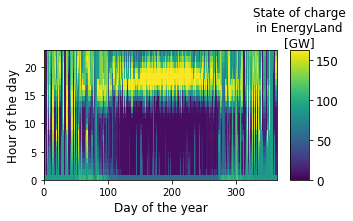

In [58]:
# If batteries are built in regionS, their storage inventory is displayed as heatmap
if storSummary.loc[('Li-ion batteries','capacity','[GW$_{el}$*h]'),'EnergyLand'] > 0:
    fig, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'EnergyLand', figsize=(5,3),
        xlabel='Day of the year', ylabel='Hour of the day',
        zlabel='State of charge\nin EnergyLand\n[GW]',
        variableName='stateOfChargeOperationVariablesOptimum')